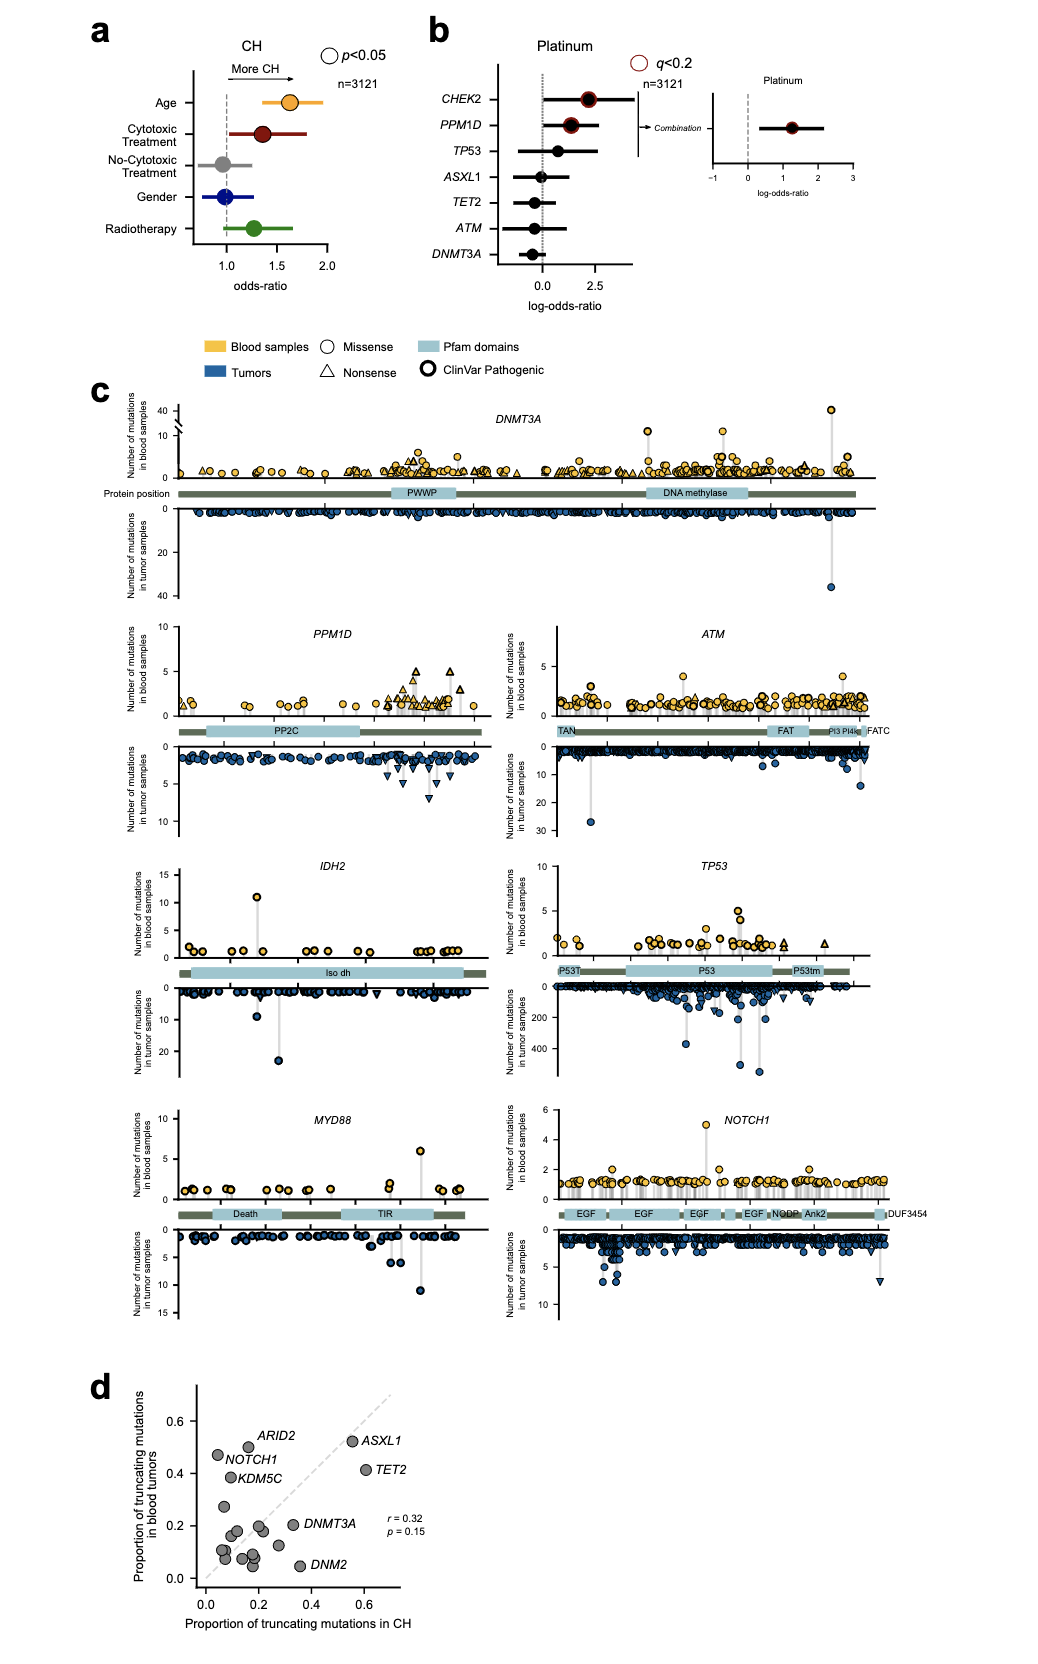

# 3A

In [69]:
file_reverse_calling = '/Users/picho/projects/collaborations/bbglab/CH/clonal_hematopoiesis_code/data_VAF/HMF/vaf_filter/HMF_FULL/HMF_full.vep.sorted.tsv.filtered.toUSE.gz'



In [70]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
import sys
sys.path.insert(0,'../src/scripts/')

from regressions import main_regression, do_logistic_reg
from scipy.stats import pearsonr
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np 
import json 

def config_params(font_size=7):

    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.rcParams['font.sans-serif'] = ['arial']
    plt.rcParams['font.size'] = font_size
    plt.rcParams['font.family'] = ['sans-serif']
    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams['mathtext.fontset'] = 'custom'
    plt.rcParams['mathtext.cal'] = 'arial'
    plt.rcParams['mathtext.rm'] = 'arial'
config_params(font_size=7)

In [72]:
list_drivers = json.load(open('../data/tables/list_driver_discovery.json'))
tup, dic_CH_gene, mut_s, dic_CH_gene2 = main_regression(file_reverse_calling, list_drivers)


/Users/picho/opt/anaconda3/envs/neopipe/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/picho/opt/anaconda3/envs/neopipe/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/picho/opt/anaconda3/envs/neopipe/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/picho/opt/anaconda3/envs/neopipe/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


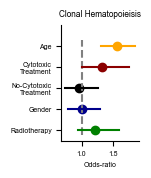

In [73]:
const, low_i, high_i, pval = tup

config_params(5)
fig, ax = plt.subplots(1, 1, figsize = (1,1.5))

plt.scatter(np.exp(const['Age']), 4, color = 'orange')
plt.plot([np.exp(low_i['Age']),
          np.exp(high_i['Age'])], [4, 4], color = 'orange')

plt.scatter(np.exp(const['TreatmentCITO']), 3, color = 'darkred')
plt.plot([np.exp(low_i['TreatmentCITO']),
          np.exp(high_i['TreatmentCITO'])], [3, 3], color = 'darkred')

plt.scatter(np.exp(const['TreatmentNOCITO']), 2, color = 'black')
plt.plot([np.exp(low_i['TreatmentNOCITO']),np.exp(high_i['TreatmentNOCITO'])], 
         [2, 2], color = 'black')

plt.scatter(np.exp(const['Gender']), 1, color = 'darkblue')
plt.plot([np.exp(low_i['Gender']),np.exp(high_i['Gender'])], 
         [1, 1], color = 'darkblue')

plt.scatter(np.exp(const['Radiotherapy']), 0, color = 'green')
plt.plot([np.exp(low_i['Radiotherapy']),np.exp(high_i['Radiotherapy'])], 
         [0, 0], color = 'green')

plt.yticks([0, 1, 2,3, 4], ['Radiotherapy', 'Gender', 
                            'No-Cytotoxic\nTreatment', 'Cytotoxic\nTreatment', 'Age'])
plt.vlines(1, -0.25, 4.3, ls = '--', color = 'grey')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
plt.xlabel('Odds-ratio')
plt.ylim(-0.5, 5)

plt.title('Clonal Hematopoieisis')
plt.show()

In [74]:
import pandas as pd
from collections import defaultdict
from statsmodels.stats.multitest import multipletests


In [75]:
s = pd.concat([low_i, high_i, const], axis = 1)
s.drop('const', inplace = True)
s.columns = ['low', 'high', 'val']
s.to_csv('values/3A.tsv', sep ='\t', index = True, header = True)

In [76]:
s

,low,high,val
Age,0.263570,0.612080,0.437825
TreatmentCITO,0.012601,0.554496,0.283548
TreatmentNOCITO,-0.299457,0.233989,-0.032734
Radiotherapy,-0.063282,0.456795,0.196757
Gender,-0.238868,0.250273,0.005702


# 3B

Platinum    0.031641
Name: PPM1D, dtype: float64 PPM1D 0.1588308103819109
Platinum    0.04538
Name: CHEK2, dtype: float64 CHEK2 0.1588308103819109


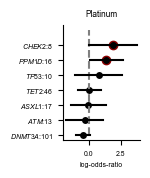

In [77]:
res_age = defaultdict(dict)
res_pval = defaultdict(dict)
res_low = defaultdict(dict)
res_high =  defaultdict(dict)
for gene, v in dic_CH_gene.items():
    const, low_i, high_i, pval = v 
    for c in const.keys():
        if c!='const':
            res_age[c][gene]= const[c]
            res_pval[c][gene]= pval[c ]
            res_low[c][gene]= low_i[c]
            res_high[c][gene]= high_i[c]
        
pvals = pd.DataFrame(res_pval)
odds = pd.DataFrame(res_age)
high_v = pd.DataFrame(res_high)
low_v = pd.DataFrame(res_low)

for set_treatment in ['Platinum']:

    tt_df = pvals[[set_treatment]]
    set_g = odds[[set_treatment]]
    res_reg_ix = set_g.sort_values(by=set_treatment, ascending = True).index.tolist()

    res_reg = tt_df.loc[res_reg_ix]
    out_q = multipletests(res_reg[set_treatment].tolist(), method = 'fdr_bh')[1]

    config_params(5)
    fig, ax = plt.subplots(1, 1, figsize = (1,1.5))
    labels = []
    plt.title(set_treatment)
    for ix, (i, row) in enumerate(res_reg.iterrows()):
        
        edgecolor = 'white'
        if (out_q[ix]<0.25)&(row.loc[set_treatment] <0.05):
            print(row, i, out_q[ix])
            edgecolor = 'darkred'
        plt.scatter(odds[set_treatment].loc[i], ix, color = 'black', edgecolor = edgecolor)
        plt.plot([low_v[set_treatment].loc[i], high_v[set_treatment].loc[i]], [ix, ix], color = 'black')
        labels.append(i)

    plt.yticks(np.arange(len(res_reg)), ["$\it{0}$:{1}".format(lab, mut_s[lab]) for lab in labels] )
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.vlines(0, 0, len(res_reg), ls = '--', color = 'grey')
    plt.xlabel('log-odds-ratio')
    plt.show()

In [78]:
s = pd.concat([low_v[set_treatment], high_v[set_treatment], odds[set_treatment]], axis = 1)
s.columns = ['low', 'high', 'val']
s.to_csv('values/3B.tsv', sep ='\t', index = True, header = True)

In [79]:
s

,low,high,val
ASXL1,-1.416558,1.362122,-0.027218
ATM,-1.762918,1.107581,-0.327668
CHEK2,0.038516,3.707636,1.873076
DNMT3A,-0.994960,0.132795,-0.431082
PPM1D,0.120443,2.619107,1.369775
TET2,-0.842760,0.939079,0.048159
TP53,-1.066811,2.607346,0.770268


0.015080613914252323


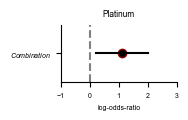

In [80]:
res_age =defaultdict(dict)
res_pval =defaultdict(dict)
res_low =defaultdict(dict)
res_high =defaultdict(dict)

for gene, v in dic_CH_gene2.items():
    const, low_i, high_i, pval = v 
    for c in const.keys():
        if c!='const':
            res_age[c][gene]= const[c]
            res_pval[c][gene]= pval[c ]
            res_low[c][gene]= low_i[c]
            res_high[c][gene]=high_i[c]
        
pvals = pd.DataFrame(res_pval)
odds = pd.DataFrame(res_age)
high_v = pd.DataFrame(res_high)
low_v = pd.DataFrame(res_low)

for set_treatment in ['Platinum']:

    tt_df = pvals[[set_treatment]]
    res_reg = tt_df.sort_values(by=set_treatment, ascending = True)
    out_q = multipletests(res_reg[set_treatment].tolist(), method = 'fdr_bh')[1][::-1]


    fig, ax = plt.subplots(1, 1, figsize = (1.5,0.75))
    labels = []
    plt.title(set_treatment)
    for ix, (i, row) in enumerate(res_reg.sort_values(by=set_treatment, ascending = False).iterrows()):        
        edgecolor = 'white'
        if out_q[ix]<0.2:
            print(out_q[ix])
            edgecolor = 'darkred'
        plt.scatter(odds[set_treatment].loc[i], ix, color = 'black', edgecolor = edgecolor)
        plt.plot([low_v[set_treatment].loc[i], high_v[set_treatment].loc[i]], [ix, ix], color = 'black')
        labels.append(i)

    plt.yticks(np.arange(len(res_reg)), ["$\it{0}$".format(lab) for lab in labels] )
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.vlines(0, -0.005, 0.005, ls = '--', color = 'grey')
    plt.ylim(-0.005, 0.005)
    plt.xlim(-1, 3)
    plt.xlabel('log-odds-ratio')
    plt.show()

# 3C

In [81]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from scipy.stats import mannwhitneyu
import matplotlib.patches as patches

import json
from brokenaxes import brokenaxes
from tqdm import tqdm

import matplotlib.ticker as ticker
import numpy as np
import gzip
import io
import os
from collections import defaultdict
import random
from matplotlib.ticker import MaxNLocator
from collections import defaultdict

# read file MSKCC mutations
from pyliftover import LiftOver

def config_params(font_size=7):

    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.rcParams['font.sans-serif'] = ['arial']
    plt.rcParams['font.size'] = font_size
    plt.rcParams['font.family'] = ['sans-serif']
    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams['mathtext.fontset'] = 'custom'
    plt.rcParams['mathtext.cal'] = 'arial'
    plt.rcParams['mathtext.rm'] = 'arial'

def vcf_reader(path):
    with gzip.open(path, 'rt') as f:
        lines = [l for l in f if not l.startswith('##')]
    return pd.read_csv(
        io.StringIO(str.join(os.linesep, lines)),
        dtype={
            '#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
            'QUAL': str, 'FILTER': str, 'INFO': str
        }, sep='\t', low_memory=False,
    ).rename(columns={'#CHROM': 'CHROM'})



def do_liftover_test(df, lo):
    try:
        lov = lo.convert_coordinate("chr"+str(df['Chromosome']), int(df['Start_Position']))[0]
        df['CHROMOSOME_HG38'] = lov[0].replace('chr', '')
        df['POSITION_HG38'] = int(lov[1])
    except:
        df['CHROMOSOME_HG38'] = None
        df['POSITION_HG38'] = None

    return df


## CH cohorts

In [82]:
# files obtained in the process_data module
file_reverse_calling_TCGA = '/Users/picho/projects/collaborations/bbglab/CH/clonal_hematopoiesis_code/data_VAF/TCGA/vaf_filter/TCGA_FULL/TCGA_full.vep.sorted.tsv.filtered.toUSE.gz'
file_reverse_calling_HMF = '/Users/picho/projects/collaborations/bbglab/CH/clonal_hematopoiesis_code/data_VAF/HMF/vaf_filter/HMF_FULL/HMF_full.vep.sorted.tsv.filtered.toUSE.gz'

tcga = pd.read_csv(file_reverse_calling_TCGA, sep ='\t')
hartwig = pd.read_csv(file_reverse_calling_HMF, sep ='\t')

genes_driver_HMF = json.load(open('../data/tables/list_driver_discovery.json'))



In [83]:
all_CH = pd.concat([tcga, hartwig], sort = False)
all_CH['MUTATION'] = all_CH['ID'].apply(lambda x : '{}:{}:{}>{}'.format(x.split('_')[0].replace('chr', ''),
                                                                        x.split('_')[1], 
                                                                        x.split('_')[2],
                                                                        x.split('_')[3]))

all_CH['PROTEIN_CHANGE'] = all_CH.apply(lambda x : '{}:{}-{}'.format(x['SYMBOL'], x['Protein_position'], 
                                                                    x['Consequence']), axis = 1)

dic_mutds = {}

for prot_ID, data in all_CH.groupby(by='PROTEIN_CHANGE'):
    mut_ids = ';'.join(data['MUTATION'].tolist())
    dic_mutds[prot_ID] = mut_ids
    
dic_count_protein = all_CH['PROTEIN_CHANGE'].value_counts().to_dict()
all_CH['NUMBER_SAMPLES'] = all_CH['PROTEIN_CHANGE'].map(dic_count_protein)
all_CH['MUTATION'] = all_CH['PROTEIN_CHANGE'].map(dic_mutds)
all_CH = all_CH[['SYMBOL', 'Protein_position', 'Consequence', 'NUMBER_SAMPLES', 'Feature', 'MUTATION']].drop_duplicates()



## Intogen Cohort

In [84]:

# get intogen mutations, easy map between proteins and mutations.
# to get this file, please go at Intogen.org and contact Nuria Lopez-Bigas
intogen_drivers = '/Users/picho/projects/collaborations/bbglab/CH/ch-drivers/data/intogen/somatic_intogen/mutations.tsv.gz'
df_into = pd.read_csv(intogen_drivers, sep ='\t')
total_samples_intogen = '/Users/picho/projects/collaborations/bbglab/CH/ch-drivers/data/intogen/somatic_intogen/cohorts.tsv'
df_tots = pd.read_csv(total_samples_intogen, sep ='\t')

df_into['PROTEIN_CHANGE'] = df_into.apply(lambda x : '{}:{}-{}'.format(x['SYMBOL'], x['Protein_position'], 
                                                                    x['CONSEQUENCE']), axis = 1)
dic_count_protein = df_into['PROTEIN_CHANGE'].value_counts().to_dict()
df_into['NUMBER_SAMPLES'] = df_into['PROTEIN_CHANGE'].map(dic_count_protein)
df_into = df_into[['SYMBOL', 'Protein_position', 'CONSEQUENCE', 'NUMBER_SAMPLES']].drop_duplicates()

/Users/picho/opt/anaconda3/envs/neopipe/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## MSKCC

In [85]:

lo = LiftOver('hg19', 'hg38')
path_to_mskcc = '~/projects/collaborations/bbglab/CH/mutpro/data/other_CH_datasets/data_mutations_extended.txt'
mskcc = pd.read_csv(path_to_mskcc,
                    skiprows = 2, sep ='\t')

mskcc = mskcc.apply(do_liftover_test, args = (lo, ), axis = 1)

mskcc = mskcc[~mskcc['POSITION_HG38'].isnull()]
mskcc['POSITION_HG38'] = mskcc['POSITION_HG38'].astype(int)

mskcc['ID'] = mskcc.apply(lambda x : '{}:{}:{}>{}'.format(x['CHROMOSOME_HG38'], x['POSITION_HG38'],
                                                          x['Reference_Allele'], x['Tumor_Seq_Allele2']), 
                          axis = 1)

hots = set(mskcc['ID'].tolist())

dic_mskcc = mskcc['ID'].value_counts().to_dict()
mskcc['NUMBER_SAMPLES'] = mskcc['ID'].map(dic_mskcc)
mskcc_lite = mskcc[['Protein_position', 'Hugo_Symbol', 'Consequence', 'NUMBER_SAMPLES']].drop_duplicates()
mskcc_lite = mskcc_lite[~mskcc_lite['Consequence'].isin(['3_prime_UTR_variant', 'downstream_gene_variant','upstream_gene_variant', 
                               '5_prime_UTR_variant', 'intron_variant', 'inframe_insertion', 
                               'inframe_deletion', 'synonymous_variant'])]

## ClinVar

In [86]:
# download clinvar data from https://www.ncbi.nlm.nih.gov/clinvar/docs/maintenance_use/
clinvar = vcf_reader('/Users/picho/projects/collaborations/bbglab/CH/ch-drivers/data/misc/clinvar_20200905.vcf.gz')
clinvar['CLNSIG'] = clinvar['INFO'].apply(lambda x : '|'.join([x.split('=')[1] for x in x.split(';') 
                                                               if 'CLNSIG' in x]))

pathologic = clinvar[clinvar['CLNSIG'].str.contains('athogenic')]

pathologic['ID'] = pathologic.apply(lambda x : '{}:{}:{}>{}'.format(x['CHROM'], x['POS'], x['REF'], 
                                                                    x['ALT']), axis = 1)

clinvar_path = set(pathologic['ID'].tolist())

<ipython-input-86-8a0a4f672f43>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pathologic['ID'] = pathologic.apply(lambda x : '{}:{}:{}>{}'.format(x['CHROM'], x['POS'], x['REF'],


## PFAM

In [87]:
# pfam downloaded from BioMart
PFAM_files = '../data/misc/pfam_biomart.tsv.gz'
PFAM_info = '../data/misc/pfam_names.info.csv'
df_pfam = pd.read_csv(PFAM_files, sep="\t", names=["ENSEMBL_GENE", "ENSEMBL_TRANSCRIPT", "START", "END", "DOMAIN"])
df_names = pd.read_csv(PFAM_info, sep="\t", names=["DOMAIN", "CLAN", "CLAN_NAME", "DOMAIN_NAME", "Long Name"])


truncating = ['splice_region_variant', 'splice_acceptor_variant', 
              'splice_donor_variant', 'stop_lost', 'stop_retained_variant', 'start_lost', 
             'frameshift_variant', 'stop_gained']

## create the needle plots (also for supplementary figure 3)

Only displaying DNMT3A

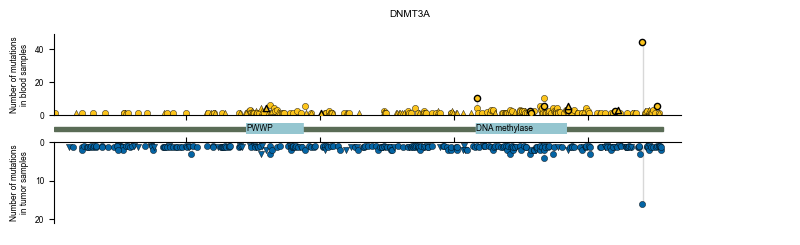

In [88]:
@ticker.FuncFormatter
def major_formatter(x, pos):
    label = str(int(-x)) if x < 0 else str(int(x))
    return label

config_params(font_size=6)
keep_proportion = defaultdict(dict)

keep_all_stats = []
main = ['DNMT3A', 'PPM1D', 'ATM', 'IDH2', 'TP53', 'MYD88', 'NOTCH1']
sec = ['TET2', 'ASXL1', 'SRSF2', 'JAK2', 'CUX1', 'FOXP1', 'GNAS', 'SF3B1', 'CHEK2']
showcase = main+sec

for g in showcase:# change showcase to  genes_driver_HMF to generate all plots

    vals_toprint_x = []
    vals_toprint_y = []
    vals_toprint_y2 = []
    vals_toprint_x2 = []
    
    sub = all_CH[all_CH['SYMBOL']==g]
    intog = df_into[df_into['SYMBOL']==g]
    transcript = sub['Feature'].tolist()[0]
    if g =='DNMT3A':
        fig, ax  = plt.subplots(3, 2, figsize = (9.5, 2.45), #sharex = True, 
                       gridspec_kw={'height_ratios':[7,0.9,7], 
                                       'width_ratios':[15,1]})
    else:
        fig, ax  = plt.subplots(3, 2, figsize = (4.25, 2.45), #sharex = True, 
                           gridspec_kw={'height_ratios':[7,0.9,7], 
                                       'width_ratios':[15,1]})

    plt.suptitle(g)
    keep_max_INTO = []

    all_prot_pos = []
    keep_mark = 0
    total = 0

    for prot_pos, data in intog.groupby(by='Protein_position'):
        for cons, d2 in data.groupby(by='CONSEQUENCE'):
            marker = "o"
            if cons in truncating:
                marker = "v"
                keep_mark+=d2['NUMBER_SAMPLES'].sum()
            total+=d2['NUMBER_SAMPLES'].sum()

            if (cons !='splice_donor_variant')&(prot_pos!='-'):
                samples_with_mut = d2['NUMBER_SAMPLES'].sum()                            
                if samples_with_mut == 1:
                    samples_with_mut = 1 + random.random()/3

                all_prot_pos.append(int(prot_pos.split('-')[-1]))
                ax[2,0].vlines(int(prot_pos.split('-')[-1])+0.25, -1,
                             -1*samples_with_mut-0.05, color = 'grey', lw = 1, alpha = 0.3, zorder = 1)
                ax[2,0].scatter(int(prot_pos.split('-')[-1])-0.75, -1*samples_with_mut, 
                              color = '#0464A4', marker = marker, s = 20, zorder= 2, linewidth=0.3, 
                                  edgecolors = 'black', )
                
                vals_toprint_x.append(prot_pos.split('-')[-1])
                vals_toprint_y.append(str(samples_with_mut))
                
                
                keep_max_INTO.append(d2['NUMBER_SAMPLES'].sum())

    ax[2,1].set_xticklabels([])
    ax[2,1].set_xticks([])
    ax[2,1].set_yticklabels([])
    ax[2,1].set_yticks([])
    ax[2,1].spines['bottom'].set_visible(False)
    ax[2,1].spines['right'].set_visible(False)
    ax[2,1].spines['top'].set_visible(False)
    ax[2,1].spines['left'].set_visible(False)

    keep_max_CH = []
    keep_mark = 0
    total = 0
    for prot_pos, data in sub[sub['SYMBOL']==g].groupby(by='Protein_position'):
        for cons, d2 in data.groupby(by='Consequence'):
            marker ="o"
            if cons in truncating:
                marker = "^"
                keep_mark+=d2['NUMBER_SAMPLES'].sum()

            total+=d2['NUMBER_SAMPLES'].sum()

            if (cons !='splice_donor_variant')&(prot_pos!='-'):

                all_prot_pos.append(int(prot_pos.split('-')[-1]))

                ax[0,0].vlines(int(prot_pos.split('-')[-1])+0.25, 0,
                             d2['NUMBER_SAMPLES'].sum()-0.05, lw = 1,  color = 'grey',
                               alpha = 0.3, zorder = 1)

                set_mskcc = data[data['MUTATION'].isin(hots)]
                color = '#FCC41C'
                zorder = 2
                keep_max_CH.append(d2['NUMBER_SAMPLES'].sum())
                all_muts_inprot = data['MUTATION'].tolist()[0].split(';')
                set_clinvar = [s for s in all_muts_inprot if s in clinvar_path]
                samples_with_mut = d2['NUMBER_SAMPLES'].sum()

                if samples_with_mut == 1:
                    samples_with_mut = 1 + random.random()/3
                if len(set_clinvar)>0:

                    ax[0,0].scatter(int(prot_pos.split('-')[-1])-0.75, samples_with_mut, 
                              color = color,  marker = marker, s = 20, alpha = 1, linewidth=1, 
                              edgecolors = 'black', zorder = 4 ) 
                else:

                    ax[0,0].scatter(int(prot_pos.split('-')[-1])-0.75, samples_with_mut, 
                              color = color,  marker = marker, s = 20, alpha = 1, linewidth=0.3, 
                              edgecolors = 'black', zorder = zorder )
                
                vals_toprint_x2.append(prot_pos.split('-')[-1])
                vals_toprint_y2.append(str(samples_with_mut))

    keep_proportion[g]['CH'] = keep_mark/total

    ax[0,1].set_xticklabels([])
    ax[0,1].set_xticks([])
    ax[0,1].set_yticklabels([])
    ax[0,1].set_yticks([])
    ax[0,1].spines['bottom'].set_visible(False)
    ax[0,1].spines['right'].set_visible(False)
    ax[0,1].spines['top'].set_visible(False)
    ax[0,1].spines['left'].set_visible(False)

    # add pFAM
    df_pfam_gene = df_pfam[(df_pfam["ENSEMBL_TRANSCRIPT"] == transcript)]
    df_pfam_gene = df_pfam_gene[["ENSEMBL_TRANSCRIPT", "START", "END", "DOMAIN"]].drop_duplicates()
    df_pfam_gene = pd.merge(df_pfam_gene, df_names[["DOMAIN", "DOMAIN_NAME"]].drop_duplicates(), how="left")
    df_pfam_gene["POS"] = df_pfam_gene.apply(lambda row: row["START"] + ((row["END"] - row["START"]) // 2), axis=1)
    df_pfam_gene["SIZE"] = df_pfam_gene.apply(lambda row: row["END"] - row["START"] + 1, axis=1)
    df_pfam_gene["Color"] = "#998ec3"

    for i, r in df_pfam_gene.iterrows():
        start_base = r['START']
        size_base = r['SIZE']
        all_prot_pos.append(start_base)
        all_prot_pos.append(start_base+size_base)

        rect = patches.FancyBboxPatch(xy=(start_base, -0.5), width=size_base, 
                                    boxstyle="round,pad=0.1", 
                                      height=2, 
                                 color='#95C6D0', alpha=1, zorder=2, 
                                     )
        ax[1,0].add_patch(rect)
        ax[1,0].annotate(text=r["DOMAIN_NAME"].replace('_', ' '), xy=(start_base, 0), 
                         fontsize=6)

    rect = patches.Rectangle(xy=(min(all_prot_pos), 0), width=max(all_prot_pos), height=0.7, 
                                 color='#5A6C56', alpha=1, zorder=1)
    ax[1,0].add_patch(rect)
    ax[1,0].set_ylim(-0.5, 1.5)

    ax[1,1].axis('off')
    ax[1, 0].axis('off')
    ax[0,0].set_ylabel('Number of mutations\nin blood samples')
    ax[2,0].set_ylabel('Number of mutations\nin tumor samples')

    ax[2,0].xaxis.tick_top()

    ax[0,0].spines['top'].set_visible(False)
    ax[0,0].spines['right'].set_visible(False)
    ax[0,0].set_ylim([0,  np.max(keep_max_CH)+5])
    ax[2,0].set_ylim([int(-1*np.max(keep_max_INTO)-5), 0])
    ax[2,0].spines['bottom'].set_visible(False)
    ax[2,0].spines['right'].set_visible(False)


    for i in range(3):
        ax[i,0].set_xlim(min(all_prot_pos), max(all_prot_pos)+30)

    ax[0,0].set_xticklabels([])
    ax[2,0].set_xticklabels([])
    ax[1,0].set_yticklabels([])
    ax[1,0].set_yticks([])

    plt.subplots_adjust(hspace = 0.15)

    bbox=plt.gca().get_position()
    offset=-.05
    plt.gca().set_position([bbox.x0, bbox.y0 + offset, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])
    ax[2,0].yaxis.set_major_formatter(major_formatter)
    
    keep_all_stats.append((g,vals_toprint_x, vals_toprint_y, vals_toprint_x2, vals_toprint_y2 ))
    
    if g == 'DNMT3A':
        plt.show()
    else:
        plt.close()


## generate all genes

In [89]:

with open('values/3C.tsv', 'wt') as main_out, open('values/supp3.tsv', 'wt') as sup_out:
    for (s, v1s, v2s, v3s, v4s) in keep_all_stats:
        v1 = s+'\t'+ ','.join(v1s)
        v2 = s+'\t'+ ','.join(v2s)
        v3 = s+'\t'+ ','.join(v3s)
        v4 = s+'\t'+ ','.join(v4s)
        values = '\n'.join([v1, v2, v3, v4])+'\n'
        if s in main:
            main_out.write(values)
        else:
            sup_out.write(values)

# 3d

In [90]:
# get intogen mutations
intogen_drivers = '/Users/picho/projects/collaborations/bbglab/CH/ch-drivers/data/intogen/somatic_intogen/mutations.tsv.gz'
df_into = pd.read_csv(intogen_drivers, sep ='\t')

/Users/picho/opt/anaconda3/envs/neopipe/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [91]:

# select only myeloid neoplasias
myeloid = ['OTHER_WGS_MM_NATLEUK2018', 'OTHER_WGS_DLBCL_NATCOM_2018', 'CBIOP_WXS_DLBCL_DFCI_2018', 
          'PCAWG_WGS_LYMPH_BNHL', 'CBIOP_WXS_CLL_IUOPA_2015', 'OTHER_WXS_AML_PRY_BEAT_2018', 
          'TCGA_WXS_LAML', 'TCGA_WXS_DLBC', 'CBIOP_WXS_MM_BROAD_TREAT', 'ICGC_WXS_LAML_KR_VARSCAN', 
          'CBIOP_WXS_MM_BROAD_UNTREAT', 'CBIOP_WXS_CLL_BROAD_2013', 
          ]


df_into = pd.read_csv(intogen_drivers, sep ='\t')

myeloid_intogen = df_into[df_into['COHORT'].isin(myeloid)]

mut_count = myeloid_intogen.groupby(['MUTATION'])['SAMPLES'].agg('sum').to_dict()

myeloid_intogen['NUMBER_SAMPLES'] = myeloid_intogen['MUTATION'].map(mut_count)
myeloid_intogen = myeloid_intogen.drop(['COHORT', 'SAMPLES'], axis = 1)
myeloid_intogen.drop_duplicates(inplace = True)
for col in myeloid_intogen.columns:
    myeloid_intogen[col] = myeloid_intogen[col].astype(str)
myeloid_intogen.drop_duplicates(inplace = True, keep = 'first')
myeloid_intogen['NUMBER_SAMPLES'] = myeloid_intogen['NUMBER_SAMPLES'].astype(int)


@ticker.FuncFormatter
def major_formatter(x, pos):
    label = str(int(-x)) if x < 0 else str(int(x))
    return label


config_params(font_size=6)
keep_proportion = defaultdict(dict)

for g in genes_driver_HMF:

    sub = all_CH[all_CH['SYMBOL']==g]
    total_samples = intog['NUMBER_SAMPLES'].sum()
    
    if len(sub)>=10:

        keep_max_CH = []
        keep_mark = 0
        total = 0
        for prot_pos, data in sub[sub['SYMBOL']==g].groupby(by='Protein_position'):
            for cons, d2 in data.groupby(by='Consequence'):
                marker ="o"
                if cons in truncating:
                    marker = "^"
                    keep_mark+=d2['NUMBER_SAMPLES'].sum()

                total+=d2['NUMBER_SAMPLES'].sum()
        keep_proportion[g]['CH'] = keep_mark/total

config_params(font_size=6)
#keep_proportion = defaultdict(dict)

for g in genes_driver_HMF:
    
    intog = myeloid_intogen[myeloid_intogen['SYMBOL']==g]
    
    if len(intog)>=10:
        #transcript = sub['TRANSCRIPT'].tolist()[0]

        plt.suptitle(g)
        keep_max_INTO = []

        all_prot_pos = []
        keep_mark = 0
        total = 0
        for prot_pos, data in intog.groupby(by='Protein_position'):
            for cons, d2 in data.groupby(by='CONSEQUENCE'):
                marker = "o"
                if cons in truncating:
                    marker = "v"
                    keep_mark+=d2['NUMBER_SAMPLES'].sum()
                total+=d2['NUMBER_SAMPLES'].sum()

        keep_proportion[g]['TUMOR'] = keep_mark/total

<ipython-input-91-953e65ad2193>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  myeloid_intogen['NUMBER_SAMPLES'] = myeloid_intogen['MUTATION'].map(mut_count)


<Figure size 640x480 with 0 Axes>

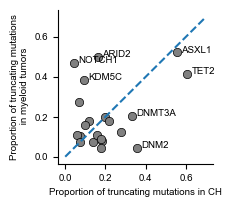

In [92]:
config_params(7)

fig, ax = plt.subplots(1,1, figsize = (2,2))

xv = []
yv = []
labs = []

for g in keep_proportion:
    if 'TUMOR' in keep_proportion[g]:
        if 'CH' in keep_proportion[g]:
            if keep_proportion[g]['TUMOR']>0:
                plt.scatter(keep_proportion[g]['CH'], 
                           keep_proportion[g]['TUMOR'], 
                           color = 'grey', edgecolors = 'black', lw = 0.5)

                if (keep_proportion[g]['TUMOR']>0.3) or  (keep_proportion[g]['CH']>0.3):
                    plt.text(keep_proportion[g]['CH']+0.02, 
                               keep_proportion[g]['TUMOR'],
                            g)
                xv.append(keep_proportion[g]['CH'])
                yv.append(keep_proportion[g]['TUMOR'])
                labs.append(g)

#sns.regplot(xv, yv)
plt.plot([0, 0.7], [0,0.7], '--')
plt.ylabel('Proportion of truncating mutations\n in myeloid tumors')
plt.xlabel('Proportion of truncating mutations in CH')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

In [93]:
v1 = ','.join(map(str, xv))
v2 = ','.join(map(str, yv))
v3 = ','.join(map(str, labs))

values = '\n'.join([v3, v1, v2])
with open('values/3D.tsv', 'wt') as outfile:
    outfile.write(values)

In [94]:

df_full = pd.read_csv('/Users/picho/projects/collaborations/bbglab/CH/ch-drivers/data/intogen/merged_run/mutations.tsv', sep ='\t')

# get HMF mutations
df_TCGA = df_full[df_full['COHORT']=='OTHER_WXS_TCGA_FULL']
df_HMF =  df_full[df_full['COHORT']=='OTHER_WGS_HMF_FULL']

mut_count = df_into.groupby(['MUTATION'])['SAMPLES'].agg('sum').to_dict()

df_into['NUMBER_SAMPLES'] = df_into['MUTATION'].map(mut_count)
df_into = df_into.drop(['COHORT', 'SAMPLES'], axis = 1)
df_into.drop_duplicates(inplace = True)
for col in df_into.columns:
    df_into[col] = df_into[col].astype(str)
df_into.drop_duplicates(inplace = True, keep = 'first')
df_into['NUMBER_SAMPLES'] = df_into['NUMBER_SAMPLES'].astype(int)

all_CH = pd.concat([df_TCGA, df_HMF])

mut_count = all_CH.groupby(['MUTATION'])['SAMPLES'].agg('sum').to_dict()

all_CH['NUMBER_SAMPLES'] = all_CH['MUTATION'].map(mut_count)
all_CH = all_CH.drop(['COHORT', 'SAMPLES'], axis = 1)
all_CH.drop_duplicates(inplace = True)

for col in all_CH.columns:
    all_CH[col] = all_CH[col].astype(str)

all_CH.drop_duplicates(inplace = True, keep = 'first')
all_CH['NUMBER_SAMPLES'] = all_CH['NUMBER_SAMPLES'].astype(int)

/Users/picho/opt/anaconda3/envs/neopipe/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<ipython-input-95-a9c56d01131d>:208: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2, 0].set_yticklabels(new_l)


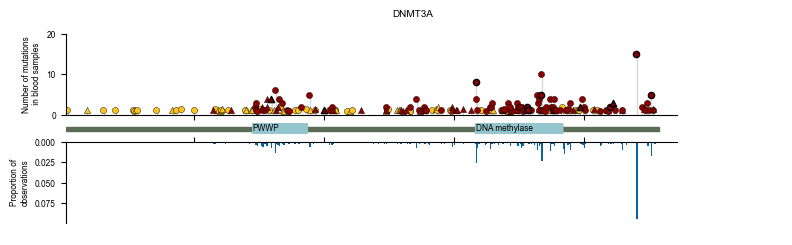

In [95]:
@ticker.FuncFormatter
def major_formatter(x, pos):
    label = str(int(-x)) if x < 0 else str(int(x))
    return label

config_params(font_size=6)
keep_proportion = defaultdict(dict)
keep_all_stats = []

showcase = ['DNMT3A', 'PPM1D', 'ATM', 'IDH2', 'TP53', 'MYD88', 'NOTCH1', 
            'TET2', 'AXSL1', 'SRSF2', 'JAK2', 'CUX1', 'FOXP1', 'GNAS', 'SF3B1', 'CHEK2']
for g in showcase:

    sub = all_CH[all_CH['SYMBOL']==g]
    intog = mskcc_lite[mskcc_lite['Hugo_Symbol']==g]
    total_samples = intog['NUMBER_SAMPLES'].sum()
    
    vals_toprint_x = []
    vals_toprint_y = []
    vals_toprint_y2 = []
    vals_toprint_x2 = []
    
    if len(intog):
        
        transcript = sub['TRANSCRIPT'].tolist()[0]
        if g !='DNMT3A':
            fig, ax  = plt.subplots(3, 2, figsize = (4.5, 2.45), #sharex = True, 
                               gridspec_kw={'height_ratios':[7,0.9,7], 
                                               'width_ratios':[15,1]})
        else:
            fig, ax  = plt.subplots(3, 2, figsize = (9.25, 2.45), #sharex = True, 
                               gridspec_kw={'height_ratios':[7,0.9,7], 
                                           'width_ratios':[15,1]})
        plt.suptitle(g)
        keep_max_INTO = []
        all_prot_pos = []
        
        keep_mark = 0
        total = 0
        for prot_pos, data in intog.groupby(by='Protein_position'):
            for cons, d2 in data.groupby(by='Consequence'):
                marker = "o"
                if cons in truncating:
                    marker = "v"
                    keep_mark+=d2['NUMBER_SAMPLES'].sum()
                total+=d2['NUMBER_SAMPLES'].sum()

                if (cons !='splice_donor_variant')&(prot_pos!='-'):
                    samples_with_mut = d2['NUMBER_SAMPLES'].sum()                            
                    if samples_with_mut == 1:
                        samples_with_mut = 1 + random.random()/3

                    all_prot_pos.append(int(prot_pos))
                    ax[2,0].bar(prot_pos, -1*samples_with_mut/total_samples, width = 2, 
                                  color = '#0464A4',  #marker = marker, s = 20, zorder= 2, linewidth=0.3, 
                               )#   edgecolors = 'black', )
                    keep_max_INTO.append(d2['NUMBER_SAMPLES'].sum())
                    
                    vals_toprint_x.append(str(prot_pos).split('-')[-1])
                    vals_toprint_y.append(str(samples_with_mut/total_samples))

        ax[2,1].set_xticklabels([])
        ax[2,1].set_xticks([])
        ax[2,1].set_yticklabels([])
        ax[2,1].set_yticks([])
        ax[2,1].spines['bottom'].set_visible(False)
        ax[2,1].spines['right'].set_visible(False)
        ax[2,1].spines['top'].set_visible(False)
        ax[2,1].spines['left'].set_visible(False)

        keep_max_CH = []
        keep_mark = 0
        total = 0
        for prot_pos, data in sub[sub['SYMBOL']==g].groupby(by='Protein_position'):
            for cons, d2 in data.groupby(by='CONSEQUENCE'):
                marker ="o"
                if cons in truncating:
                    marker = "^"
                    keep_mark+=d2['NUMBER_SAMPLES'].sum()

                total+=d2['NUMBER_SAMPLES'].sum()

                if (cons !='splice_donor_variant')&(prot_pos!='-'):

                    all_prot_pos.append(int(prot_pos.split('-')[-1]))

                    ax[0,0].vlines(int(prot_pos.split('-')[-1])+0.25, 0,
                                 d2['NUMBER_SAMPLES'].sum()-0.05, lw = 1,  color = 'grey',
                                   alpha = 0.3, zorder = 1)

                    set_mskcc = data[data['MUTATION'].isin(hots)]
                    color = '#FCC41C'
                    zorder = 2
                    if len(set_mskcc)>0:

                        color = 'darkred'
                        zorder = 3

                    keep_max_CH.append(d2['NUMBER_SAMPLES'].sum())

                    set_clinvar = data[data['MUTATION'].isin(clinvar_path)]
                    samples_with_mut = d2['NUMBER_SAMPLES'].sum()

                    if samples_with_mut == 1:
                        samples_with_mut = 1 + random.random()/3

                    if len(set_clinvar)>0:

                        ax[0,0].scatter(int(prot_pos.split('-')[-1])-0.75, samples_with_mut, 
                                  color = color,  marker = marker, s = 20, alpha = 1, linewidth=1, 
                                  edgecolors = 'black', zorder = 4 ) 
                    else:

                        ax[0,0].scatter(int(prot_pos.split('-')[-1])-0.75, samples_with_mut, 
                                  color = color,  marker = marker, s = 20, alpha = 1, linewidth=0.3, 
                                  edgecolors = 'black', zorder = zorder )
                        
                    vals_toprint_x2.append(prot_pos.split('-')[-1])
                    vals_toprint_y2.append(str(samples_with_mut))

        keep_proportion[g]['CH'] = keep_mark/total
        ax[0,1].set_xticklabels([])
        ax[0,1].set_xticks([])
        ax[0,1].set_yticklabels([])
        ax[0,1].set_yticks([])
        ax[0,1].spines['bottom'].set_visible(False)
        ax[0,1].spines['right'].set_visible(False)
        ax[0,1].spines['top'].set_visible(False)
        ax[0,1].spines['left'].set_visible(False)

        # add pFAM
        df_pfam_gene = df_pfam[(df_pfam["ENSEMBL_TRANSCRIPT"] == transcript)]
        df_pfam_gene = df_pfam_gene[["ENSEMBL_TRANSCRIPT", "START", "END", "DOMAIN"]].drop_duplicates()
        df_pfam_gene = pd.merge(df_pfam_gene, df_names[["DOMAIN", "DOMAIN_NAME"]].drop_duplicates(), how="left")
        df_pfam_gene["POS"] = df_pfam_gene.apply(lambda row: row["START"] + ((row["END"] - row["START"]) // 2), axis=1)
        df_pfam_gene["SIZE"] = df_pfam_gene.apply(lambda row: row["END"] - row["START"] + 1, axis=1)
        df_pfam_gene["Color"] = "#998ec3"


        for i, r in df_pfam_gene.iterrows():
            start_base = r['START']
            size_base = r['SIZE']
            all_prot_pos.append(start_base)
            all_prot_pos.append(start_base+size_base)
            rect = patches.FancyBboxPatch(xy=(start_base, -0.5), width=size_base, 
                                        boxstyle="round,pad=0.1", 
                                          height=2, 
                                     color='#95C6D0', alpha=1, zorder=2, 
                                         )
            ax[1,0].add_patch(rect)
            ax[1,0].annotate(text=r["DOMAIN_NAME"].replace('_', ' '), xy=(start_base, 0), 
                             fontsize=6)


        rect = patches.Rectangle(xy=(min(all_prot_pos), 0), width=max(all_prot_pos), height=0.7, 
                                     color='#5A6C56', alpha=1, zorder=1)
        ax[1,0].add_patch(rect)
        ax[1,0].set_ylim(-0.5, 1.5)

        ax[1,1].axis('off')
        ax[1, 0].axis('off')
        ax[0,0].set_ylabel('Number of mutations\n in blood samples')
        ax[2,0].set_ylabel('Proportion of\nobservations')
        ax[2,0].xaxis.tick_top()

        ax[0,0].spines['top'].set_visible(False)
        ax[0,0].spines['right'].set_visible(False)
        ax[0,0].set_ylim([0,  np.max(keep_max_CH)+5])
        ax[2,0].spines['bottom'].set_visible(False)
        ax[2,0].spines['right'].set_visible(False)


        for i in range(3):
            ax[i,0].set_xlim(min(all_prot_pos), max(all_prot_pos)+30)
            

        ax[0,0].set_xticklabels([])
        ax[2,0].set_xticklabels([])
        ax[1,0].set_yticklabels([])
        ax[1,0].set_yticks([])

        plt.subplots_adjust(hspace = 0.15)   
        lab = ax[2, 0].get_yticklabels()
        new_l = [i.get_text() for i in lab]
        
        bbox=plt.gca().get_position()
        offset=-.05
        plt.gca().set_position([bbox.x0, bbox.y0 + offset, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])

        fig.canvas.draw()
        
        locs = ax[0, 0].get_yticks()
        labs = ax[2, 0].get_yticklabels()

        max_v = np.max(locs)
        if max_v % 2 == 0:
            keeps = max_v/2
        else:
            max_v = max_v-1
            keeps = max_v/2
        new = [0, keeps, max_v]
        ax[0, 0].set_yticks(new)
        
        new_l = []
        for lab in labs:
            new_l.append(lab.get_text().replace('−', ''))
        
        ax[2, 0].set_yticklabels(new_l)
        
        keep_all_stats.append((g, vals_toprint_x, vals_toprint_y, vals_toprint_x2, vals_toprint_y2 ))
                 
        if g == 'DNMT3A':
            plt.show()
        else:
            plt.close()


In [96]:
with open('values/supp4A.tsv', 'wt') as outfile:
    for (s, v1s, v2s, v3s, v4s) in keep_all_stats:
        v1 = s+'\t'+ ','.join(v1s)
        v2 = s+'\t'+ ','.join(v2s)
        v3 = s+'\t'+ ','.join(v3s)
        v4 = s+'\t'+ ','.join(v4s)
        values = '\n'.join([v1, v2, v3, v4])+'\n'
        outfile.write(values)

# Supplementary figure 4b

In [97]:
@ticker.FuncFormatter
def major_formatter(x, pos):
    label = str(int(-x)) if x < 0 else str(int(x))
    return label


config_params(font_size=6)
keep_proportion = defaultdict(dict)

for g in genes_driver_HMF:

    sub = all_CH[all_CH['SYMBOL']==g]
    intog = mskcc_lite[mskcc_lite['Hugo_Symbol']==g]
    total_samples = intog['NUMBER_SAMPLES'].sum()
    
    if len(sub)>=10:

        keep_max_CH = []
        keep_mark = 0
        total = 0
        for prot_pos, data in sub[sub['SYMBOL']==g].groupby(by='Protein_position'):
            for cons, d2 in data.groupby(by='CONSEQUENCE'):
                marker ="o"
                if cons in truncating:
                    marker = "^"
                    keep_mark+=d2['NUMBER_SAMPLES'].sum()

                total+=d2['NUMBER_SAMPLES'].sum()
        keep_proportion[g]['CH'] = keep_mark/total

config_params(font_size=6)

for g in genes_driver_HMF:
    
    intog = mskcc_lite[mskcc_lite['Hugo_Symbol']==g]
    
    if len(intog)>=10:
        transcript = sub['TRANSCRIPT'].tolist()[0]

        plt.suptitle(g)
        keep_max_INTO = []

        all_prot_pos = []
        keep_mark = 0
        total = 0
        for prot_pos, data in intog.groupby(by='Protein_position'):
            for cons, d2 in data.groupby(by='Consequence'):
                marker = "o"
                if cons !='missense_variant':
                    marker = "v"
                    keep_mark+=d2['NUMBER_SAMPLES'].sum()
                total+=d2['NUMBER_SAMPLES'].sum()


        keep_proportion[g]['TUMOR'] = keep_mark/total

(0.8911177886131311, 3.0965801925858073e-07)


<Figure size 640x480 with 0 Axes>

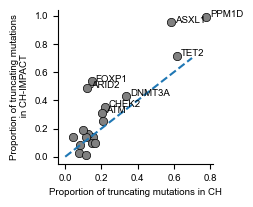

In [98]:
config_params(7)

fig, ax = plt.subplots(1,1, figsize = (2,2))

xv = []
yv = []
labs = []
for g in keep_proportion:
    if 'TUMOR' in keep_proportion[g]:
        if 'CH' in keep_proportion[g]:
            if keep_proportion[g]['TUMOR']>0:
                plt.scatter(keep_proportion[g]['CH'], 
               keep_proportion[g]['TUMOR'], 
               color = 'grey', edgecolors = 'black', lw = 0.5)
                if (keep_proportion[g]['TUMOR']>0.3) or  (keep_proportion[g]['CH']>0.3):
                    plt.text(keep_proportion[g]['CH']+0.02, 
                               keep_proportion[g]['TUMOR'],
                            g)
                xv.append(keep_proportion[g]['CH'])
                yv.append(keep_proportion[g]['TUMOR'])
                labs.append(g)

plt.plot([0, 0.7], [0,0.7], '--')
plt.ylabel('Proportion of truncating mutations\n in CH-IMPACT')
plt.xlabel('Proportion of truncating mutations in CH')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print(pearsonr(xv, yv))
plt.show()

In [99]:
v1 = ','.join(map(str, xv))
v2 = ','.join(map(str, yv))
v3 = ','.join(map(str, labs))

values = '\n'.join([v3, v1, v2])
with open('values/supp4B.tsv', 'wt') as outfile:
    outfile.write(values)

# TCGA

In [100]:
list_drivers = json.load(open('../data/tables/list_driver_discovery.json'))


In [101]:
clincal_data_tcga = '/Users/picho/projects/collaborations/bbglab/CH/cluster/clinical_PANCAN_patient_with_followup_151210.tsv'
df_t = pd.read_csv(clincal_data_tcga, sep ='\t', encoding = "ISO-8859-1", 
                  low_memory=False )

aged = df_t[df_t['age_at_initial_pathologic_diagnosis']!='[Not Available]']
aged = aged[aged['gender']!='[Not Available]']
aged['age_at_initial_pathologic_diagnosis'] = aged['age_at_initial_pathologic_diagnosis'].astype(int)
dic_aging = dict(zip(aged['bcr_patient_barcode'], aged['age_at_initial_pathologic_diagnosis']))

mean_val = np.mean(list(dic_aging.values()))
ttype_patients = dict(zip(df_t['bcr_patient_barcode'], df_t['acronym']))

wanted_smoker = ['Current reformed smoker for < or = 15 years', 'Current smoker',
                'Current reformed smoker for > 15 years', 'Current Reformed Smoker, Duration Not Specified']

list_smoker = df_t[df_t['tobacco_smoking_history'].isin(wanted_smoker)]['bcr_patient_barcode'].tolist()
nonsmoker = df_t[df_t['tobacco_smoking_history']=='Lifelong Non-smoker']['bcr_patient_barcode'].tolist()
gender_patients = dict(zip(aged['bcr_patient_barcode'], aged['gender']))

number_packs = df_t[(df_t['number_pack_years_smoked']!='[Not Available]')&(~df_t['number_pack_years_smoked'].isnull())]
smoking_history_years = dict(zip(number_packs['bcr_patient_barcode'], number_packs['number_pack_years_smoked']))


In [102]:
file_reverse_calling_TCGA = '/Users/picho/projects/collaborations/bbglab/CH/clonal_hematopoiesis_code/data_VAF/TCGA/vaf_filter/TCGA_FULL/TCGA_full.vep.sorted.tsv.filtered.toUSE.gz'

df = pd.read_csv(file_reverse_calling_TCGA, 
         sep ='\t')

df = df[df['repeated_counts']==0]


In [103]:
# previous list of drivers according to iceland guys
CH_list = set(['DNMT3A', 'TET2','ASXL1', 'JAK2', 'TP53','PPM1D', 'IDH2', 
             'CBL', 'SF3B1', 'SRSF2', 'GNAS', 'KRAS', 'GNB1', 'NRAS', 
             'MYD88'])

In [104]:
subs_myeloid_full = df[df['SYMBOL'].isin(list_drivers)]

subs_myeloid_full = subs_myeloid_full[~subs_myeloid_full['Consequence'].isin(['synonymous_variant', 
                                                                      'inframe_deletion', 
                                                                      'inframe_insertion'])]


In [105]:
forbidden_samples = subs_myeloid_full[subs_myeloid_full['SYMBOL'].isin(CH_list)]["SAMPLE"].unique()
subs_myeloid_full_muts = subs_myeloid_full
subs_myeloid_full_samples = subs_myeloid_full['SAMPLE'].tolist()

## Supplementary Figure 2A

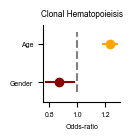

In [106]:
dic_to_reg = defaultdict(dict)

dic_gen_fix = {'MALE':0 , 'FEMALE':1}
# select data for treated samples
for sample in set(df['SAMPLE'].tolist()):
    
    # remove samples with known drivers
    age  = int(dic_aging.get(sample, mean_val))

    dic_to_reg[sample]['Age'] = age/10
    dic_to_reg[sample]['Gender'] = dic_gen_fix.get(gender_patients.get(sample, 'UNKNOWN'), 'UNKNOWN')
    dic_to_reg[sample]['CH'] = 0

    if sample in subs_myeloid_full_samples : 
        dic_to_reg[sample]['CH'] = 1

testing = pd.DataFrame(dic_to_reg).T
testing = testing.fillna(0)
testing = testing[testing['Age']>0]
testing = testing[(testing['Gender']!='UNKNOWN')]
testing['Gender'] = testing['Gender'].astype(int)
testing['CH'] = testing['CH'].astype(int)
testing['Age'] = testing['Age'].astype(float)

all_cols = testing.columns
res2, tup = do_logistic_reg(testing)


const, low_i, high_i, pval = tup


config_params(5)
fig, ax = plt.subplots(1, 1, figsize = (1,1))

plt.scatter(np.exp(const['Age']), 1, color = 'orange')
plt.plot([np.exp(low_i['Age']),
          np.exp(high_i['Age'])], [1, 1], color = 'orange')

plt.scatter(np.exp(const['Gender']), 0, color = 'darkred')
plt.plot([np.exp(low_i['Gender']),
          np.exp(high_i['Gender'])], [0, 0], color = 'darkred')

plt.yticks([0, 1], ['Gender', 'Age'])
plt.vlines(1, -0.25, 1.3, ls = '--', color = 'grey')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
plt.xlabel('Odds-ratio')
plt.ylim(-0.5, 1.5
        )

plt.title('Clonal Hematopoieisis')
plt.show()

In [107]:
s = pd.concat([low_i, high_i, const], axis = 1)
s.drop('const', inplace = True)
s.columns = ['low', 'high', 'val']
s.to_csv('values/supp2A.tsv', sep ='\t', index = True, header = True)

In [108]:
s

,low,high,val
Age,0.166361,0.248007,0.207184
Gender,-0.247736,-0.024448,-0.136092


In [109]:
l = list_drivers #['ATM', 'ASXL1', 'TET2', 'DNMT3A', 'CHEK2', 'TP53', 'PPM1D']

dic_CH_gene = {}
allowed_samples = testing.index
for gene, data in subs_myeloid_full_muts.groupby(by='SYMBOL'):
    try:
        if gene in l:
            samples_affected = data['SAMPLE'].unique().tolist()
            wanted_s = [s for s in samples_affected if s in allowed_samples]
            gene_pos = testing.loc[wanted_s]
            gene_neg = testing.loc[[s for s in testing.index if s not in samples_affected]]
            gene_pos['CH'] = 1
            gene_neg['CH'] = 0

            toreg = pd.concat([gene_pos, gene_neg])
            res, tup = do_logistic_reg(toreg)
            dic_CH_gene['{} n={}'.format(gene, len(samples_affected))] = tup
    except:
        continue

res_age = {}
res_treat = {}
for gene, v in dic_CH_gene.items():
    const, low_i, high_i, pval = v 
    res_age[gene]= np.exp(const['Age']), np.exp(low_i['Age']), np.exp(high_i['Age']), pval['Age']
    
age_gene = pd.DataFrame(res_age, index = ['Val', 'LC', 'HC', 'pvalue']).T


/Users/picho/opt/anaconda3/envs/neopipe/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/picho/opt/anaconda3/envs/neopipe/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/picho/opt/anaconda3/envs/neopipe/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/picho/opt/anaconda3/envs/neopipe/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


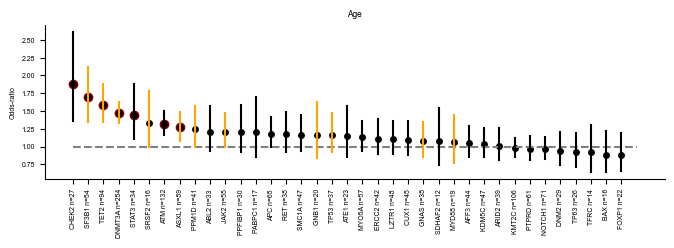

In [110]:

fig, ax = plt.subplots(1, 1, figsize = (8,2))
labels = []
plt.title('Age')
for ix, (i, row) in enumerate(age_gene.sort_values(by='Val', ascending = False).iterrows()):
    
    g = i.split(" ")[0]
    color = "black"
    if g in CH_list:
        color = "orange"
    edgecolor = 'white'
    if row['pvalue']<0.05:
        edgecolor = 'darkred'
        
    plt.plot([ix, ix], [row['LC'], row['HC']], color = color)
    plt.scatter(  ix, row['Val'], color = 'black', edgecolor = edgecolor)
    labels.append(i)

plt.xticks(np.arange(len(age_gene)), ["{}".format(lab) for lab in labels], 
          rotation = 90)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.hlines(1, 0, len(age_gene), ls = '--', color = 'grey')
plt.ylabel('Odds-ratio')
plt.show()

In [111]:
age_gene.head()

,Val,LC,HC,pvalue
ABL2 n=33,1.210811,0.935300,1.567478,0.146450
AFF3 n=44,1.044067,0.846057,1.288419,0.687740
APC n=65,1.180963,0.988103,1.411465,0.067489
ARID2 n=39,1.011144,0.810619,1.261273,0.921721
ASXL1 n=89,1.269326,1.081286,1.490067,0.003553


In [112]:
age_gene.to_csv('values/supp2A_2.tsv', sep ='\t', index = True, header = True)

In [113]:
all_ttypes = set(ttype_patients.values())

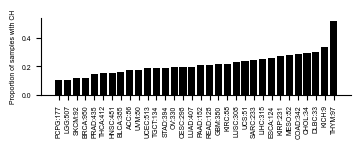

In [114]:
dic_prop_t = {}
dic_n = {}
for t in all_ttypes:
    ttype_samples = [s for s,v in ttype_patients.items() if v ==t]
    samples_d = len(subs_myeloid_full[subs_myeloid_full["SAMPLE"].isin(ttype_samples)]["SAMPLE"].unique())
    total_s = len(df[df["SAMPLE"].isin(ttype_samples)]["SAMPLE"].unique())
    dic_prop_t[t]=samples_d/total_s
    dic_n[t] = total_s
    
prop = sorted(dic_prop_t, key=dic_prop_t.get)
fig, ax = plt.subplots(1, 1, figsize = (4, 1))
for ix, k in enumerate(prop):
    plt.bar(ix, dic_prop_t[k], color = "black")

plt.ylabel("Proportion of samples with CH")

plt.xticks(range(len(prop)), ['{}:{}'.format(x, dic_n[x]) for x in prop], rotation = 90)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [115]:
pd.DataFrame.from_dict(dic_prop_t,orient = 'index').head()

,0
PRAD,0.144828
STAD,0.187817
LUAD,0.194103
SARC,0.244635
UVM,0.175000


In [116]:
pd.DataFrame.from_dict(dic_prop_t,orient = 'index').to_csv('values/supp2B.tsv', sep ='\t', 
                                                           index = True, header = True)


/Users/picho/opt/anaconda3/envs/neopipe/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


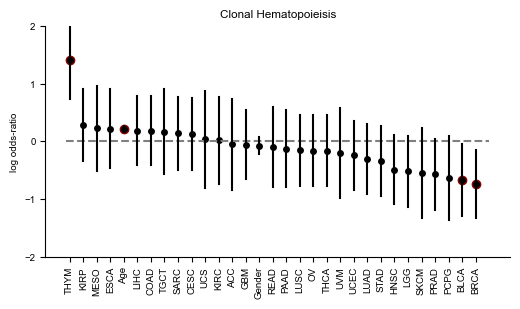

In [117]:
dic_to_reg = defaultdict(dict)

dic_gen_fix = {'MALE':0 , 'FEMALE':1}
# select data for treated samples
for sample in set(df['SAMPLE'].tolist()):
        
    if sample in ttype_patients:
        age  = int(dic_aging.get(sample, mean_val))

        dic_to_reg[sample]['Age'] = age/10
        dic_to_reg[sample]['Gender'] = dic_gen_fix.get(gender_patients.get(sample, 'UNKNOWN'), 'UNKNOWN')
        
        dic_to_reg[sample][ttype_patients[sample]]=1
        dic_to_reg[sample]['CH_sc'] = 0

        if sample in subs_myeloid_full_samples : #subs_myeloid_full:
            dic_to_reg[sample]['CH_sc'] = 1

             
testing = pd.DataFrame(dic_to_reg).T
testing = testing.fillna(0)
testing = testing[testing['Age']>0]
testing = testing[(testing['Gender']!='UNKNOWN')]
testing['Gender'] = testing['Gender'].astype(int)
testing['Age'] = testing['Age'].astype(float)
testing['CH'] = testing['CH_sc'].astype(float)

testing.drop("CH_sc", axis = 1, inplace = True)

keep_c = []
for c in testing.columns:
    if len(testing[testing[c]>0])>50:
        keep_c.append(c)
testing = testing[keep_c]
all_cols = testing.columns
res2, tup = do_logistic_reg(testing)

const, low_i, high_i, pval = tup

config_params(7)
fig, ax = plt.subplots(1, 1, figsize = (6,3))

keep = []
reg_df = pd.DataFrame(tup, index = ['Val', 'LC', 'HC', 'pvalue']).T
labels = []
reg_df.drop("const", inplace = True)
for ix, (i, row) in enumerate(reg_df.sort_values(by='Val', ascending = False).iterrows()):
    
    edgecolor = 'white'
    if row['pvalue']<0.05:
        edgecolor = 'darkred'
    plt.plot([ix, ix], [row['LC'], row['HC']], color = color)
    plt.scatter(  ix, row['Val'], color = 'black', edgecolor = edgecolor)
    labels.append(i)

plt.hlines(0, -0.25, len(reg_df), ls = '--', color = 'grey')
plt.xticks(np.arange(len(reg_df)), ["{}".format(lab) for lab in labels], 
          rotation = 90)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
plt.ylabel('log odds-ratio')
plt.ylim(-1.5, 2)
plt.yticks([-2, -1, 0, 1, 2])
plt.title('Clonal Hematopoieisis')
plt.show()

In [118]:
reg_df.to_csv('values/supp2B_2.tsv', sep ='\t', index = True, header = True)

In [119]:
reg_df.head()

,Val,LC,HC,pvalue
Age,0.214689,0.167306,0.262073,6.662650e-19
Gender,-0.074660,-0.217537,0.068218,3.057575e-01
UCEC,-0.238285,-0.833475,0.356905,4.326454e-01
BRCA,-0.738637,-1.325882,-0.151392,1.369201e-02
SKCM,-0.544511,-1.329754,0.240732,1.741158e-01


In [120]:
nsamples = testing.sum().to_dict()
res_regression = pd.DataFrame(keep)

## remove APC

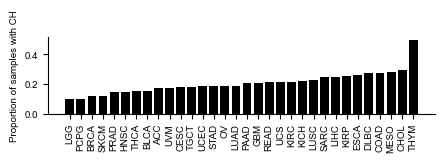

In [121]:
dic_prop_t = {}
subs_myeloid_full2 = subs_myeloid_full[subs_myeloid_full["SYMBOL"]!="APC"]

for t in all_ttypes:
    ttype_samples = [s for s,v in ttype_patients.items() if v ==t]
    samples_d = len(subs_myeloid_full2[subs_myeloid_full2["SAMPLE"].isin(ttype_samples)]["SAMPLE"].unique())
    total_s = len(df[df["SAMPLE"].isin(ttype_samples)]["SAMPLE"].unique())
    dic_prop_t[t]=samples_d/total_s
    
prop = sorted(dic_prop_t, key=dic_prop_t.get)
fig, ax = plt.subplots(1, 1, figsize = (5, 1))
for ix, k in enumerate(prop):
    plt.bar(ix, dic_prop_t[k], color = "black")

plt.ylabel("Proportion of samples with CH")

plt.xticks(range(len(prop)), prop, rotation = 90)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [122]:
subs_myeloid_full_samples2 = subs_myeloid_full2['SAMPLE'].tolist()

# Supplementary figure 2C (VAF/dNdScv)

In [123]:
import seaborn as sns

In [124]:
hmf_v = '/Users/picho/projects/collaborations/bbglab/CH/clonal_hematopoiesis_code/data_VAF/HMF/vaf_filter/HMF_FULL/HMF_full.vep.sorted.tsv.filtered.toUSE.gz'
tcga_v = '/Users/picho/projects/collaborations/bbglab/CH/clonal_hematopoiesis_code/data_VAF/TCGA/vaf_filter/TCGA_FULL/TCGA_full.vep.sorted.tsv.filtered.toUSE.gz'


In [125]:
# paths to raw dNdScv outputs
path_dnds = "../data/intogen/dndscv/OTHER_WGS_HMF_FULL.dndscv.tsv.gz"
df_hmf_full = pd.read_csv(path_dnds, sep ="\t")
path_dnds = "../data/intogen/dndscv/OTHER_WXS_TCGA_FULL.dndscv.tsv.gz"
df_tcga_full = pd.read_csv(path_dnds, sep ="\t")
path_dnds = "../data/intogen/dndscv/OTHER_WXS_CH_IMPACT_PANEL.dndscv.tsv.gz"
df_impact_full = pd.read_csv(path_dnds, sep ="\t")


In [126]:
hmf_muts = pd.read_csv(hmf_v, sep ='\t')
tcga_muts = pd.read_csv(tcga_v, sep ="\t")


In [127]:
hmf_muts = hmf_muts[~hmf_muts['Consequence'].isin(['synonymous_variant', 
                                                  'inframe_deletion', 
                                                  'inframe_insertion'])]

In [128]:
tcga_muts = tcga_muts[~tcga_muts['Consequence'].isin(['synonymous_variant', 
                                                      'inframe_deletion', 
                                                      'inframe_insertion'])]

In [129]:
res = pd.read_csv("../data/tables/driver_discovery_table.tsv", sep ="\t", index_col=0)

In [130]:
dic_res_t = defaultdict(list)
dic_res_class = defaultdict(list)

for i, row in res.iterrows():
    for c in res.columns:
        v = row[c]
        if v==2:
            dic_res_t[i].append(c)
        if v ==1:
            dic_res_class[i].append(c)


In [131]:
color_cgc = {0:'white', 1:'#0E1137'}
color_myeloid = {0:'white', 1:'#C83737'}
color_ch = {0:'white', 1:'#548F25'}

In [132]:
config_params(5)

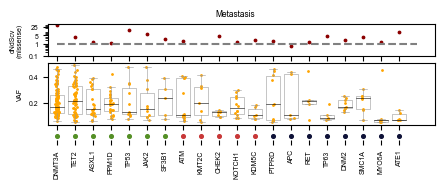

In [133]:
list_hmf = dic_res_t["Metastasis"]

fig, ax = plt.subplots(3, 1, figsize = (5, 1.5),  gridspec_kw={'height_ratios':[1,2, 0.25],},
                       sharex=True)

plt.suptitle("Metastasis")

list_vafs = []
list_w = []
pos = 0
list_genes = []
xvals = []

for f in list_hmf:
    if len(hmf_muts[hmf_muts["SYMBOL"]==f])>4:
        
        xvals.append(f +'\t' + ','.join(map(str, hmf_muts[hmf_muts["SYMBOL"]==f]["VAF"].tolist())))
        
        list_vafs.append(hmf_muts[hmf_muts["SYMBOL"]==f]["VAF"].tolist())
        miss_cv = df_hmf_full[df_hmf_full["gene_name"]==f]["wmis_cv"].tolist()[0]
        list_w.append(miss_cv)
        list_genes.append(f)
        
        if f in dic_res_class["CH"]:
            color = "#548F25"
        elif f in dic_res_class["Myeloid"]:
            color = "#C83737"
        elif f in dic_res_class["CGC"]:
            color = "#0E1137"
        ax[2].scatter(pos, 0, color = color, s = 7)
        pos+=1

sns.boxplot(data = list_vafs, ax = ax[1], fliersize=False, 
            color = 'white',
            medianprops={'color':'black'}, linewidth = 0.4) #zorder=0)

x = list(itertools.chain.from_iterable([[0 + i] * len(l) for i, l in enumerate(list_vafs)]))
x += np.random.normal(0, 0.05, size=len(x))
y = list(itertools.chain.from_iterable(list_vafs))

ax[0].scatter(np.arange(len(list_w)), list_w, s = 3,
              color = "darkred")

ax[1].scatter(x, y, s=1, alpha=1,
              c="orange",  )  # scatter zorder=5

ax[0].plot([0, len(list_w)], [1,1], 
           ls = "--", color = "grey")

ax[0].set_yscale("log")
ax[0].set_yticks([0.1, 1, 5, 25])
ax[0].set_yticklabels([0.1, 1, 5, 25])
ax[0].set_ylabel("dNdScv\n(missense)")
ax[1].set_ylabel("VAF")
ax[2].set_xticks(np.arange(len(list_genes)))
ax[2].set_xticklabels(list_genes, rotation = 90)

ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].spines['bottom'].set_visible(False)
ax[2].spines['left'].set_visible(False)
ax[2].set_yticks([])

plt.show()

In [134]:
values = '\n'.join(xvals)
with open('values/supp2C_1.tsv', 'wt') as outfile:
    outfile.write(values)

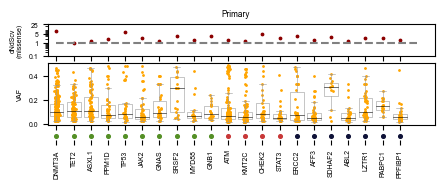

In [135]:
list_hmf = dic_res_t["Primary"]

fig, ax = plt.subplots(3, 1, figsize = (5, 1.5),  gridspec_kw={'height_ratios':[1,2, 0.25],},
                       sharex=True)

plt.suptitle("Primary")

list_vafs = []
list_w = []
list_genes = []
pos = 0
xvals = []

for f in list_hmf:
    if len(tcga_muts[tcga_muts["SYMBOL"]==f])>4:
        list_vafs.append(tcga_muts[tcga_muts["SYMBOL"]==f]["VAF"].tolist())
        
        xvals.append(f +'\t' +','.join(map(str, tcga_muts[tcga_muts["SYMBOL"]==f]["VAF"].tolist())))

        miss_cv = df_tcga_full[df_tcga_full["gene_name"]==f]["wmis_cv"].tolist()[0]
        list_w.append(miss_cv)
        list_genes.append(f)
                
        if f in dic_res_class["CH"]:
            color = "#548F25"
        elif f in dic_res_class["Myeloid"]:
            color = "#C83737"
        elif f in dic_res_class["CGC"]:
            color = "#0E1137"
        ax[2].scatter(pos, 0, color = color, s = 7)
        pos+=1

sns.boxplot(data = list_vafs, ax = ax[1], fliersize=False, 
            color = 'white',
            medianprops={'color':'black'}, linewidth = 0.4) #zorder=0)


x = list(itertools.chain.from_iterable([[0 + i] * len(l) for i, l in enumerate(list_vafs)]))
x += np.random.normal(0, 0.05, size=len(x))
y = list(itertools.chain.from_iterable(list_vafs))


ax[0].scatter(np.arange(len(list_w)), list_w, s = 3,
              color = "darkred")

ax[1].scatter(x, y, s=1, alpha=1,
              c="orange",  )  

ax[0].plot([0, len(list_w)], [1,1], 
           ls = "--", color = "grey")


ax[0].set_yscale("log")
ax[0].set_yticks([0.1, 1, 5, 25])
ax[0].set_yticklabels([0.1, 1, 5, 25])
ax[0].set_ylabel("dNdScv\n(missense)")
ax[1].set_ylabel("VAF")
ax[2].set_xticks(np.arange(len(list_genes)))
ax[2].set_xticklabels(list_genes, rotation = 90)

ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].spines['bottom'].set_visible(False)
ax[2].spines['left'].set_visible(False)
ax[2].set_yticks([])

plt.show()

In [136]:
values = '\n'.join(xvals)
with open('values/supp2C_2.tsv', 'wt') as outfile:
    outfile.write(values)